In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime
from statsmodels.tsa.api import VAR
from tqdm import tqdm
import time
import joblib

In [ ]:
data = pd.read_parquet("/content/drive/MyDrive/LSE Capstone G Drive/Train Val Test Sets/2D Dataframes/2d_data_cleaned.parquet")
val_set_original = pd.read_parquet("/content/drive/MyDrive/LSE Capstone G Drive/Train Val Test Sets/2D Dataframes/val_set_2D.parquet")
test_set_original = pd.read_parquet("/content/drive/MyDrive/LSE Capstone G Drive/Train Val Test Sets/2D Dataframes/test_set_2D.parquet")

# Convert date and set index
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')

# Parameters
parameter_columns = ["KD490", "ZSD", "RRS490", "RRS443", "CHL", "MICRO", "BBP", "CDM"]

data

,lat_5km,lon_5km,KD490,ZSD,RRS490,RRS443,CHL,MICRO,BBP,CDM
date,,,,,,,,,,
2025-01-26,49.15,-10.75,0.042622,21.520136,0.006361,0.006838,0.197671,0.285306,0.003873,0.016502
2025-01-26,49.15,-10.70,0.043422,21.033817,0.007095,0.007484,0.206785,0.285306,0.003873,0.016502
2025-01-26,49.15,-10.65,0.043873,20.774261,0.005769,0.006020,0.212015,0.285306,0.003873,0.016502
2025-01-26,49.15,-10.60,0.043365,21.072351,0.003745,0.004274,0.206158,0.285306,0.003873,0.016502
2025-01-26,49.15,-10.55,0.044909,20.184818,0.003184,0.004002,0.224094,0.285306,0.003873,0.016502
...,...,...,...,...,...,...,...,...,...,...
2024-11-17,52.25,-4.50,0.135265,5.545503,0.005816,0.006983,1.893622,0.266766,0.003325,0.015229
2024-11-17,52.25,-4.45,0.135620,5.536804,0.005816,0.006983,1.903060,0.266766,0.003325,0.015229
2024-11-17,52.25,-4.40,0.130535,5.786188,0.005816,0.006983,1.782744,0.266766,0.003325,0.015229


# VAR with first differencing

## Conduct first differencing on variables grouped by grid point to maintain the spatial structure

In [ ]:
# 1. First difference per grid point function (same as before)
def first_difference_per_grid(df):
    dfs = []

    for (lat, lon), group in df.groupby(['lat_5km', 'lon_5km']):
        group = group.sort_values('date').copy()
        # Keep lat_5km, lon_5km, and date columns
        vars_to_diff = group.columns.difference(['lat_5km', 'lon_5km', 'date'])
        group[vars_to_diff] = group[vars_to_diff].diff()
        group = group.iloc[1:]  # drop first NaN row

        dfs.append(group)

    diff_df = pd.concat(dfs, ignore_index=False)

    # Ensure 'date' is a column (not index)
    if 'date' not in diff_df.columns:
        if 'date' in diff_df.index.names:
            diff_df = diff_df.reset_index(level='date')
        else:
            diff_df = diff_df.reset_index()

    print(diff_df.reset_index(drop=True))

    return diff_df.reset_index(drop=True)

## Create the adjusted train, validation, test sets

In [ ]:
# 2. Adjust date ranges to account for lost first observation
adjusted_train_dates = [('2022-01-28', '2022-11-20'), ('2023-01-28', '2023-11-17')]
val_dates = ('2024-01-26', '2024-07-31')
test_dates = [('2024-08-01', '2024-11-17'), ('2025-01-26', '2025-07-21')]

def filter_by_date_ranges(df, date_ranges):
    masks = [(df['date'] >= start) & (df['date'] <= end) for start, end in date_ranges]
    combined_mask = masks[0]
    for mask in masks[1:]:
        combined_mask = combined_mask | mask
    return df[combined_mask]

# 3. Function to prepare datasets from original full df
def prepare_diff_datasets(df):
    print("Differencing per grid point...")
    df_diff = first_difference_per_grid(df)
    print(f"Differenced data shape: {df_diff.shape}")

    print("Splitting differenced data into train, val, test sets...")
    train_set = filter_by_date_ranges(df_diff, adjusted_train_dates)
    val_set = df_diff[(df_diff['date'] >= val_dates[0]) & (df_diff['date'] <= val_dates[1])]
    test_set = filter_by_date_ranges(df_diff, test_dates)

    print(f"Train set shape: {train_set.shape}")
    print(f"Validation set shape: {val_set.shape}")
    print(f"Test set shape: {test_set.shape}")

    return train_set, val_set, test_set

## VAR model on the differenced data

In [ ]:
def train_VAR_model(train_set, val_set, MAX_lags=1):
    val_predictions = {}
    last_train_values = {}
    start_time = time.time()
    total_points = len(unique_lats) * len(unique_lons)

    with tqdm(total=total_points, desc="Fitting VAR Models") as pbar:
        for lat in unique_lats:
            for lon in unique_lons:
                current_point = f"Grid Point ({lat}, {lon})"
                pbar.set_postfix_str(current_point)

                # Filter by grid point
                train_ts_full = train_set[(train_set['lat_5km'] == lat) & (train_set['lon_5km'] == lon)].copy()
                val_ts_full = val_set[(val_set['lat_5km'] == lat) & (val_set['lon_5km'] == lon)].copy()

                if len(train_ts_full) < 10 or len(val_ts_full) < 1:
                    pbar.update(1)
                    continue

                train_ts_full = train_ts_full.sort_values('date').set_index('date').drop(['lat_5km', 'lon_5km'], axis=1)
                val_ts_full = val_ts_full.sort_values('date').set_index('date').drop(['lat_5km', 'lon_5km'], axis=1)

                # --- Split train set into known seasonal blocks and trim gap-crossing lags ---#
                block_2022 = train_ts_full['2022-01-28':'2022-11-20']
                block_2023 = train_ts_full['2023-01-28':'2023-11-17']
                # Drop first 1 row of 2023 so no lag comes from 2022 block
                cleaned_train = pd.concat([block_2022, block_2023.iloc[1:]])
                cleaned_train = cleaned_train.reset_index(drop=True)

                # Skip constant series
                if cleaned_train.nunique().max() <= 1:
                    pbar.update(1)
                    continue

                # Store the last observed train value (needed for reconstruction)
                last_train_values[(lat, lon)] = cleaned_train.iloc[-1].values

                # Select lag via AIC if desired
                best_lag = 1
                best_aic = np.inf
                for lag in range(1, MAX_lags + 1):
                    try:
                        m = VAR(cleaned_train).fit(lag)
                        if m.aic < best_aic:
                            best_aic = m.aic
                            best_lag = lag
                    except:
                        continue

                model = VAR(cleaned_train)
                result = model.fit(best_lag)

                # Forecast on validation set: one-step ahead forecasts using true lags
                val_array = val_ts_full.values
                forecast_steps = len(val_array)
                preds = []

                for t in range(forecast_steps):
                    try:
                        if t < best_lag:
                            needed_from_train = best_lag - t
                            history = np.vstack([
                                cleaned_train.values[-needed_from_train:],
                                val_array[:t]
                            ])
                        else:
                            history = val_array[t - best_lag:t]

                        next_pred = result.forecast(y=history, steps=1)
                        preds.append(next_pred[0])
                    except Exception as e:
                        preds.append(np.full(cleaned_train.shape[1], np.nan))
                        continue

                val_predictions[(lat, lon)] = np.array(preds)
                pbar.set_postfix_str(f"{current_point} - lag selected: {best_lag}")
                pbar.update(1)

    end_time = time.time()
    print(f"\nTraining finished in {end_time - start_time:.2f} seconds.")
    return val_predictions, last_train_values

## Reconstructing the forecasts by inversing the differenced data to compare with original validation data

In [ ]:
def reconstruct_from_diff_val_df(val_predictions, val_df, last_train_values, variable_columns):
    reconstructed_predictions = {}

    # Ensure val_df is sorted correctly by time
    val_df = val_df.sort_values(by='date')

    # Pivot the dataframe to get time series per (lat, lon)
    grouped = val_df.groupby(['lat_5km', 'lon_5km'])

    for (lat, lon), diffs in val_predictions.items():
        group = grouped.get_group((lat, lon))
        true_vals = group[variable_columns].values  # shape (T, num_vars)

        T, num_vars = diffs.shape
        preds = np.zeros_like(diffs)

        # First prediction uses last train value
        preds[0] = last_train_values[(lat, lon)] + diffs[0]

        # Remaining predictions use true validation values at time t to get t+1
        for t in range(1, T):
            preds[t] = true_vals[t - 1] + diffs[t]

        reconstructed_predictions[(lat, lon)] = preds

    return reconstructed_predictions

## Evaluation Metrics on Reconstructed Forecasts: SMAPE, RMSE, MAE

In [ ]:
def evaluation_metrics(val_predictions, val_set):
    # --- Aggregate all predictions and ground truths across grid points ---
    all_preds = []
    all_truths = []

    for (lat, lon), preds in val_predictions.items():
        val_ts = val_set[(val_set['lat_5km'] == lat) & (val_set['lon_5km'] == lon)]
        val_ts = val_ts.sort_values('date')[parameter_columns].values

        if preds.shape != val_ts.shape:
            continue

        all_preds.append(preds)
        all_truths.append(val_ts)

    # --- Stack into arrays ---
    all_preds = np.vstack(all_preds)   # shape: (N, 8)
    all_truths = np.vstack(all_truths) # shape: (N, 8)

    # --- Metrics ---
    global_mape = np.mean(np.abs((all_truths - all_preds) / np.clip(np.abs(all_truths), 1e-8, None)), axis=0)
    global_rmse = np.sqrt(np.mean((all_truths - all_preds) ** 2, axis=0))
    global_mae  = np.mean(np.abs(all_truths - all_preds), axis=0)
    global_smape = np.mean(2 * np.abs(all_truths - all_preds) /
                          np.clip(np.abs(all_truths) + np.abs(all_preds), 1e-8, None), axis=0)

    # --- Combine into a DataFrame (optional, nice to view tabular) ---
    metrics_df = pd.DataFrame(
        [global_mape*100, global_smape*100, global_rmse, global_mae],
        index=['MAPE (%)','SMAPE (%)', 'RMSE', 'MAE'],
        columns=parameter_columns
    )

    print(metrics_df.round(3))

    # --- Heatmap ---
    plt.figure(figsize=(12, 5))
    sns.heatmap(metrics_df, annot=True, fmt=".3f", cmap='coolwarm', cbar_kws={'label': 'Error'})
    plt.title("Global Metrics per Variable, VAR model with 1 lag (Validation Set)")
    plt.xlabel("Variable")
    plt.ylabel("Metric")
    plt.tight_layout()
    plt.show()

# Running the model

In [ ]:
# Step 1: Prepare differenced and split datasets
train_set, val_set, test_set = prepare_diff_datasets(data)

# Step 2: Get unique lats/lons from train or full differenced dataset
unique_lats = train_set['lat_5km'].unique()
unique_lons = train_set['lon_5km'].unique()

Differencing per grid point...
              date  lat_5km  lon_5km     KD490       ZSD    RRS490    RRS443  \
0       2022-01-28    49.15   -10.75 -0.001261  0.710464  0.000199  0.000710   
1       2022-01-29    49.15   -10.75  0.000000  0.000000  0.000000  0.000000   
2       2022-01-30    49.15   -10.75 -0.001304  0.845871 -0.000025  0.000397   
3       2022-01-31    49.15   -10.75 -0.001942  1.221535 -0.000314 -0.000674   
4       2022-02-01    49.15   -10.75  0.000000  0.000000  0.000000  0.000000   
...            ...      ...      ...       ...       ...       ...       ...   
9107899 2025-07-17    52.25    -4.30  0.000000  0.000000  0.000000  0.000000   
9107900 2025-07-18    52.25    -4.30  0.000000  0.000000  0.000000  0.000000   
9107901 2025-07-19    52.25    -4.30  0.000000  0.000000  0.000000  0.000000   
9107902 2025-07-20    52.25    -4.30  0.000000  0.000000  0.000000  0.000000   
9107903 2025-07-21    52.25    -4.30  0.000000  0.000000  0.000000  0.000000   

        

In [ ]:
print(train_set['date'].nunique())
print(val_set['date'].nunique())
print(test_set['date'].nunique())

591
188
286


In [ ]:
# Step 3: Train VAR models and get validation predictions
val_predictions, last_train_values = train_VAR_model(train_set, val_set, MAX_lags=1)

Fitting VAR Models: 100%|██████████| 10899/10899 [09:05<00:00, 19.96it/s, Grid Point (52.25, -2.15)]


Training finished in 545.93 seconds.


In [ ]:
# Step 4: Reconstruct the validation set to original scale using true observed values
variable_columns = ['KD490', 'ZSD', 'RRS490', 'RRS443', 'CHL', 'MICRO', 'BBP', 'CDM']
reconstructed = reconstruct_from_diff_val_df(val_predictions, val_set_original, last_train_values, variable_columns)

           KD490    ZSD  RRS490  RRS443     CHL    MICRO     BBP     CDM
MAPE (%)   9.285  9.989  15.991  27.146  20.249  648.199  24.637  30.693
SMAPE (%)  9.386  9.882  14.119  18.249  17.536   45.271  19.666  22.583
RMSE       0.029  1.791   0.002   0.002   0.942    3.883   0.005   0.080
MAE        0.010  0.868   0.001   0.001   0.241    0.887   0.002   0.017


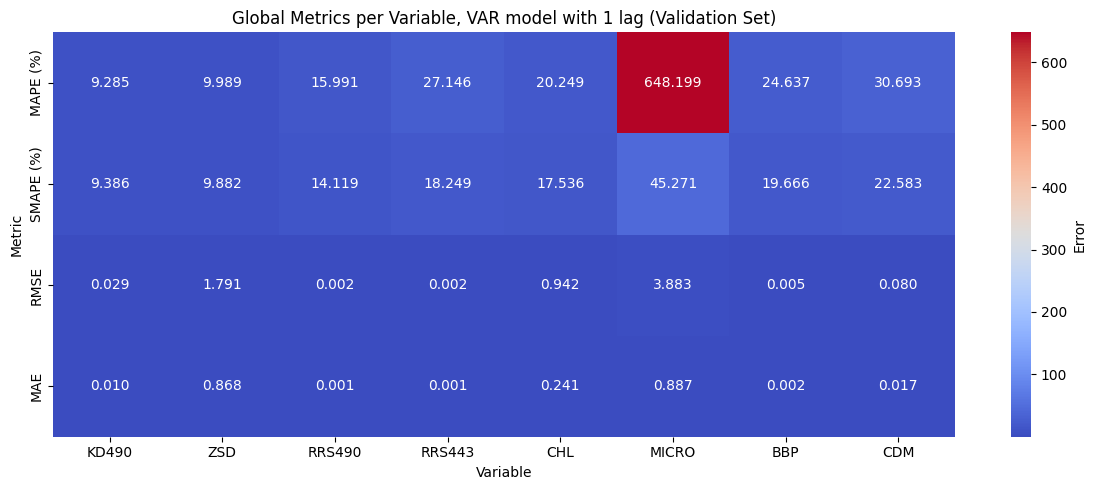

In [ ]:
# Step 5: Compute the evaluation metrics
evaluation_metrics(reconstructed, val_set_original)